# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI). Also calculates the 24-hour rainfall distribution from a set of rainfall data values for 5-minute through 24-hour durations  (see NRCS Engineering Handbook Part 630 https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=43924.wba and sample the published NOAA Atlas 14 hyetographs for the 24 hour storm event

__Input__: HUC number (can be huc8, 10 or 12)

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. A spreadsheet with sheets for each recurrence interval that includes the NRCS nested hyetograph for the 24 hour storm and NOAA atlas 14 hyetographs. (*Project ID + _temporal_PrecipTable.xlsx*)

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import precip_hyetograph_nrcs
from hydromet_traditional import*
from pyproj import Transformer

### Parameters: 

In [2]:
## Filenames and fields:
Project_Area = 'salt_creek'          # Project area name
HUC = '071200040403'               # Domain huc number (e.g. 071200040505)

In [2]:
#variables
precip_table = '{0}_{1}_PrecipTable.xlsx'.format(Project_Area, HUC)  # NOAA Data

## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table

## Options:
display_plots = True
display_print = True
brute_force_projection = None

In [3]:
#download NHD geodatabase if not already saved
select_data = HUC
filter_field = 'HUC'+str(len(HUC))

gdb_dir = nhd_download(select_data,inputs_dir)

opening: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/Beta/GDB/NHDPLUS_H_0712_HU4_GDB.zip
saving to: C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Inputs\NHDPLUS_H_0712_HU4_GDB.gdb


##### Convert all paths to objects:

In [4]:
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [5]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

#atlas 14 data for sampling
atlas_14_sample_duration = 24

#nrcs data for nesting
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h'] 
dur_names = ['5min', '10min', '15min', '30min', '60min', '2hr', '3hr', '6hr', '12hr', '24hr'] 

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
temporal_dir = datarepository_dir/'Temporal_Distributions'

verbose = True

## Read NHD Data:

### Load as a geodataframe:

In [6]:
gdf = gpd.read_file(gdb_dir,layer='WBDHU'+str(len(HUC)))

check_attributes(gdf)

gdf.head(1)

,TNMID,MetaSourceID,SourceDataDesc,SourceOriginator,SourceFeatureID,LoadDate,NonContributingAreaAcres,NonContributingAreaSqKm,AreaSqKm,AreaAcres,...,States,HUC12,HUType,HUMod,ToHUC,Shape_Length,Shape_Area,NHDPlusID,VPUID,geometry
0,{5A1CD9F9-7694-4B56-A6CF-72D607C5D10E},None,None,None,None,2013-01-18T07:08:17+00:00,0.0,0.0,0.0,4900.99,...,IN,071200010506,S,"CD,TF,NC",071200010806,0.612867,0.002132,2.200080e+13,0712,"MULTIPOLYGON (((-86.59465 41.30647, -86.59412 ..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [7]:
print('Original Coordinate Reference System:', gdf.crs)

Original Coordinate Reference System: epsg:4269


### Extract the area of interest, reproject, and plot:

In [8]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

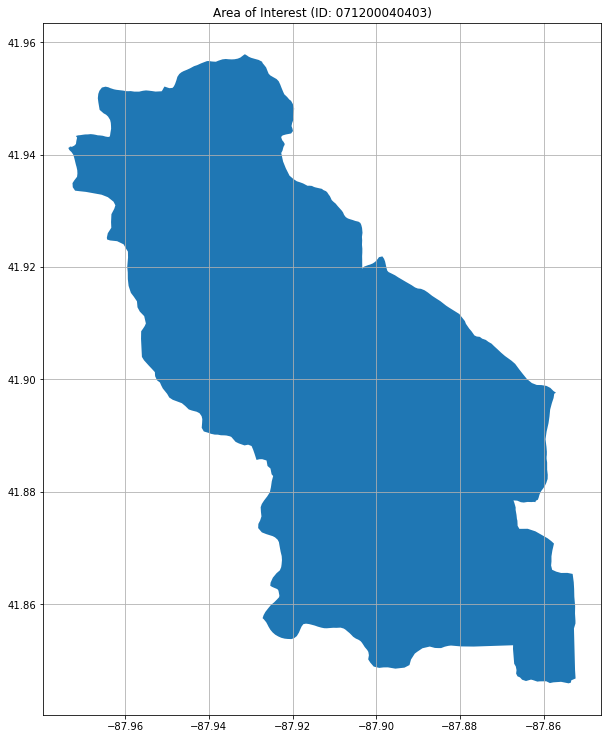

In [9]:
geo_df = gdf1.to_crs(epsg = noaa_data_crs)
plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           2
Region           1
Percent_area     100.0


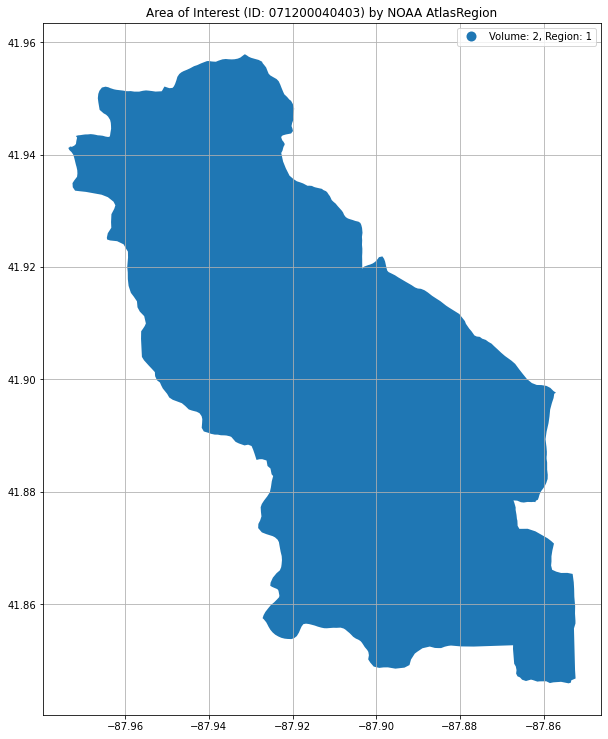

In [10]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

In [11]:
##Only required for Amite (bug in NOAA data)
if Project_Area == 'Amite': 
    volume = '9' # Manually specify the volume if the input shapes do not overlap below. This is needed for Amite
    volume_dict = {'Volume':volume,'Region':1,'Percent_area':100.0}

### Load Atlas 14 volume code from json:

In [12]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: orb


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [13]:
all_zips_list, noaa_url = get_noaa_precip_values(vol_code,durations, verbose = True)

30 files found for 05m
30 files found for 10m
30 files found for 15m
30 files found for 30m
30 files found for 60m
30 files found for 02h
30 files found for 03h
30 files found for 06h
30 files found for 12h
30 files found for 24h


### Iterate through zip files and build a table:

In [14]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

299 orb1000yr24hau.zip
299
992 Seconds


,region,TR,duration,statistic,value
0,orb,1,05m,Expected Value,0.386898
1,orb,1,05m,Lower (90%),0.350173
2,orb,1,05m,Upper (90%),0.428990
3,orb,2,05m,Expected Value,0.454439
4,orb,2,05m,Lower (90%),0.412765


None


---
## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [15]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save Precipitation Table:

In [16]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_PrecipTable.xlsx'.format(Project_Area, select_data))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
print('0.1-percent table \n',table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
#print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.save()

0.1-percent table 
       Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           2.379714     2.117918     2.702459
2           2.891592     2.574480     3.286755
5           3.701163     3.283337     4.207439
10          4.377602     3.863020     4.969184
25          5.377439     4.696378     6.100418
50          6.235949     5.403653     7.084265
100         7.189133     6.155010     8.170133
200         8.249031     6.967184     9.403857
500         9.851490     8.155633    11.288959
1000       11.241816     9.135367    12.981429


,Volume,Region,Percent_area
AOI,,,
HUC12_071200040403,2,1,100.0


---

## Calculate NRCS nested hyetograph function 

In [17]:
#select events to prepare nested distribution
Return_Intervals = events_initialize('NOAA')

In [18]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in Return_Intervals:
    precip_df = c_df.loc[str(evnt)][['duration', 'value']].set_index('duration')
    hyetos[str(evnt)] = precip_hyetograph_nrcs(precip_df)   

#### Plot to check behavior of 100 year recurrence interval

In [19]:
h100 = hyetos['100'].rename(columns = {'ratio':'Cumulative Distribution','t_step':'Time','slope':'100 year Distribution'}, inplace = False)

<AxesSubplot:xlabel='Time (hours)', ylabel='Precipitation (inches)'>

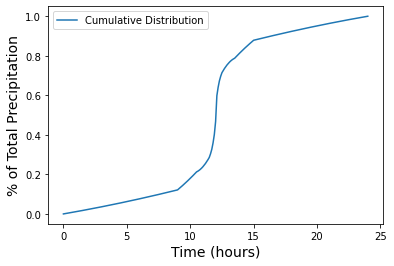

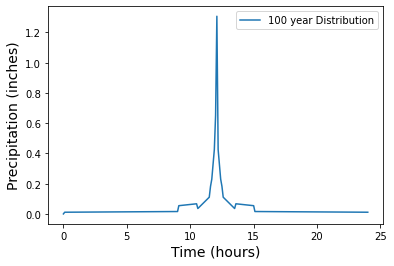

In [20]:
p1 = h100.plot('Time','Cumulative Distribution')
p1.legend()
p1.set_xlabel('Time (hours)', fontsize=14)
p1.set_ylabel('% of Total Precipitation', fontsize=14)

p2 = h100.plot('Time', '100 year Distribution')
p2.legend()
p2.set_xlabel('Time (hours)', fontsize=14)
p2.set_ylabel('Precipitation (inches)', fontsize=14)

p1
p2

### Save Nested Hyetograph:

In [21]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_nrcs_PrecipTable.xlsx'.format(Project_Area, select_data))

for i, d in enumerate(c_df.index.astype(str).tolist()[1:10]):
    table = hyetos[d][['ratio', 'slope']]
    hyetos[d].to_excel(writer, sheet_name = f'nrcs_hye_{d}')
    #print(table)
writer.save()

---

## Apply NOAA Atlas 14 hyetograph distributions 

#### NOAA Atlas 14 Volume and Region:

In [22]:
if 'Volume' not in locals(): 
    volume, region = get_volume_region(precip_table_dir, display_print = display_print)

NOAA Atlas 14: Volume 2, Region 1


#### Temporal distribution data map:

In [23]:
datarepository_dir

WindowsPath('C:/Users/cusmith/OneDrive - Stantec Office 365/git/Hydromet/DataRepository')

In [24]:
qmap = get_temporal_map(datarepository_dir, Temporal_Distribution_Data_Map, volume, region, atlas_14_sample_duration, display_print)

{'map': {'q1': [0, 9], 'q2': [11, 20], 'q3': [22, 31], 'q4': [33, 42]}, 'skiprows': 12}


#### Precipitation temporal distribution:

In [25]:
raw_temporals = get_temporals(temporal_dir, volume, region, atlas_14_sample_duration, qmap, display_print)

,0.0,8.3,16.7,25.0,33.3,41.7,50.0,58.3,66.7,75.0,83.3,91.7,100.0
percent of duration,,,,,,,,,,,,,
10%,0,55.1,85.7,96.2,99.1,99.9,100.0,100.0,100.0,100.0,100.0,100.0,100.0
20%,0,41.8,71.0,86.7,94.4,97.9,99.3,99.8,100.0,100.0,100.0,100.0,100.0


None


#### Temporal quartile ranks:

In [26]:
qrank = get_quartile_rank(datarepository_dir, Temporal_Quartile_Ranks, volume, region, atlas_14_sample_duration, display_print)

[0.36, 0.26, 0.23, 0.15]


---

## Show Temporal Distributions:

### Reformat and plot the temporal distribution data:

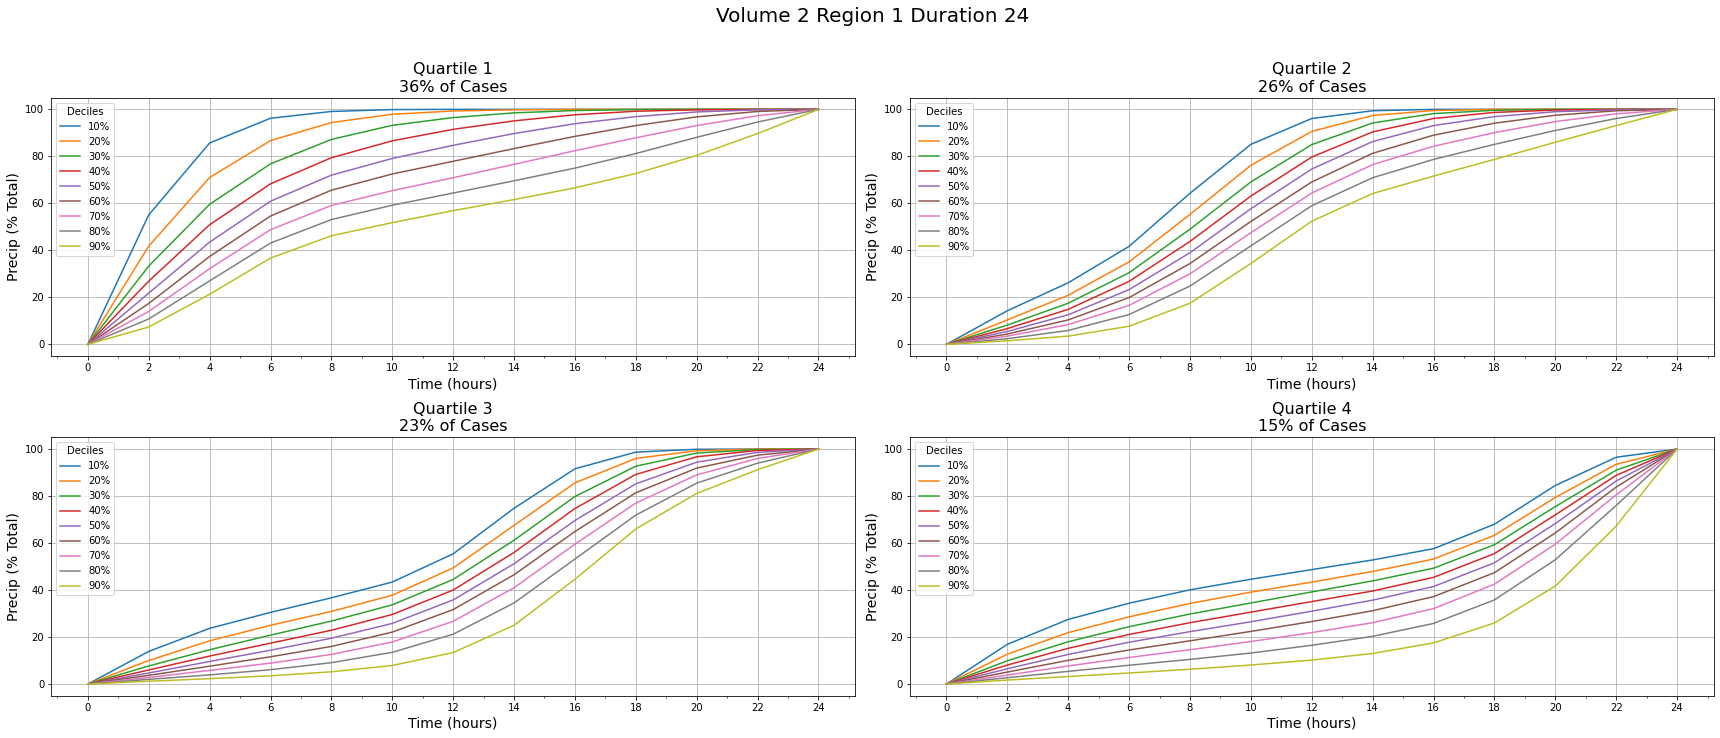

In [27]:
curve_group = get_quartiles(raw_temporals, atlas_14_sample_duration, qrank, qmap, volume, region, plot = display_plots)

## Select Temporal Distributions:

#### Combine deciles and quartiles into 1 dataframe

In [28]:
all_distro = pd.concat([curve_group['q1'], curve_group['q2'], curve_group['q3'], curve_group['q4']], axis=1, keys=['q1','q2','q3','q4'])
all_distro.head(2)

q1                                                   q2  ...   q3  \
        10%   20%   30%   40%   50%   60%   70%   80%  90%   10%  ...  90%   
hours                                                             ...        
0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0  ...  0.0   
2.0    55.1  41.8  33.3  26.9  21.8  17.4  14.0  10.8  7.4  14.3  ...  1.2   

         q4                                           
        10%   20%  30%  40%  50%  60%  70%  80%  90%  
hours                                                 
0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2.0    16.9  12.7  9.9  8.1  6.5  5.1  3.8  2.7  1.7  

[2 rows x 36 columns]

#### Set Conservative Sampling Plan

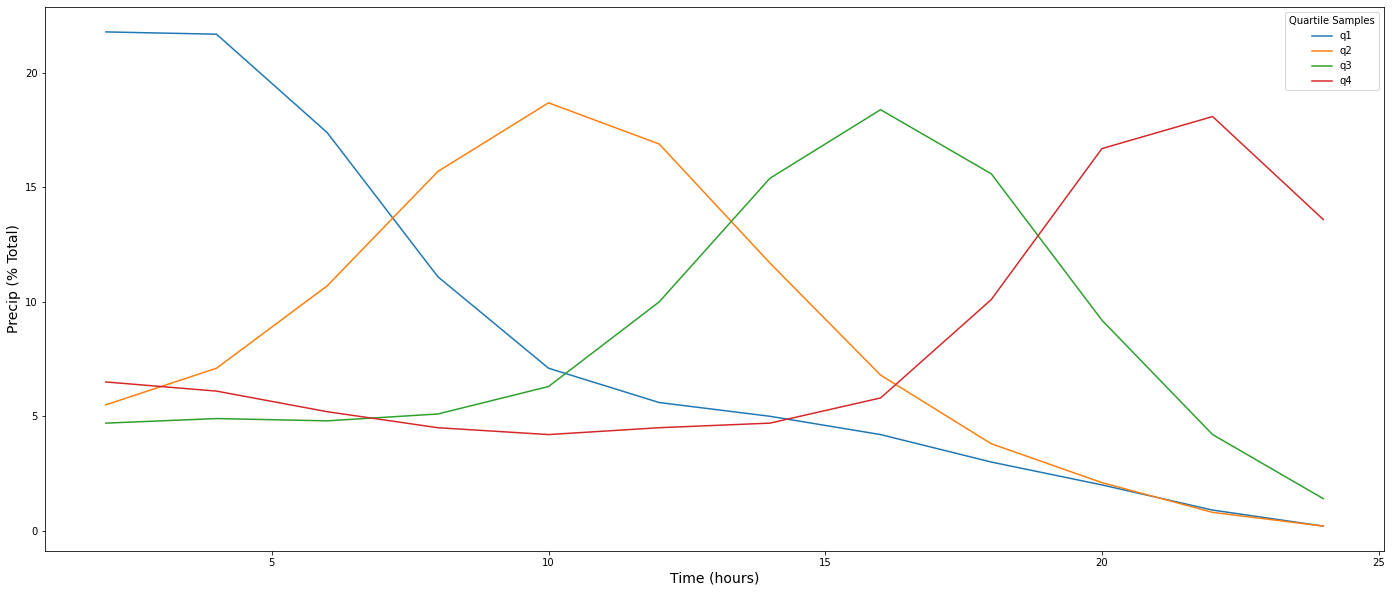

In [29]:
## User selected limiting sample from each quartile:
samples = ['50%', '50%', '50%', '50%']

## Plot selected samples:
select_distro = pd.concat([all_distro['q1'][samples[0]], all_distro['q2'][samples[1]], all_distro['q3'][samples[2]], all_distro['q4'][samples[3]]], axis=1, keys=['q1','q2','q3','q4'])
select_distro_hyetograph = pd.concat([all_distro.diff()['q1'][samples[0]], all_distro.diff()['q2'][samples[1]], all_distro.diff()['q3'][samples[2]], all_distro.diff()['q4'][samples[3]]], axis=1,keys=['q1', 'q2', 'q3', 'q4'])
ax = select_distro_hyetograph.plot(figsize=(24, 10))
ax.legend(title = 'Quartile Samples')
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Precip (% Total)', fontsize=14)
ax.plot();

#### Check sample weights

In [30]:
## Weighted probability of each sample:
weights_df = pd.DataFrame(data = qrank, columns = ['weight'])
weights_df.index = ['q1', 'q2', 'q3', 'q4']
weights_df

,weight
q1,0.36
q2,0.26
q3,0.23
q4,0.15


---

## Save the Results:

In [31]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, select_data))

for i, d in enumerate(select_distro.columns):
    table = select_distro[d]/100.0
    table.to_excel(writer, sheet_name = f'atlas_hye_{d}')
weights_df.to_excel(writer, sheet_name = 'atlas_hye_weights')
 
writer.save()

## END